In [1]:
%matplotlib inline

In [2]:
import time
import os
import sys
from collections import defaultdict
import json

import xml.etree.ElementTree as ET
from xml.dom import minidom

import numpy as np
import pandas as pd

import openslide
from PIL import Image
from PIL import ImageDraw


# Annotation: labeled patches from .xml, .csv, .svs
(and display all for developer sanity check)

## Convert xml & csv input to a region_id dict

## Create heirarchical mask set from the region_id dict

## Write labeled patches from the heirarchical mask set

```text
Questions:
    We should still create a threshold mask as before to omit any blank areas included in an annotation?
    Yes.
 
    When an entire label is eclipsed by a higher priority label (Empty) should the function issue a warning?
    No.
 
    The TFRecord could now have more than one “class_label” and,
    the “label” field that TFRecord owns is still just a sequence number… 
    thus it may be more difficult to select training/test subsets.
    Ergo: should each “class_label” aka “class_label_text” be in a different TFRecord file?
    No - one file is fine
```

In [3]:
"""
from collections import defaultdict
import json

from xml.dom import minidom

import openslide

from PIL import Image
from PIL import ImageDraw
"""
def get_labels_dict(class_labels_id_file_name):
    """ labels_dict = get_labels_dict(class_labels_id) 
    Args:
        class_labels_id_file_name:  .csv file with columns [Label, ID, Priority]
    Returns:
        labels_dict:                python dict of dicts:
                                        {label_id_(n): {ID: x, Priority: y}, ...}
    """
    # allocate dict of dicts
    labels_dict = defaultdict(dict)
    
    # read the file
    lines = ''
    try:        
        with open(class_labels_id_file_name, 'r') as fh:
            lines = fh.readlines()
    except:
        print('failed opening: ', class_labels_id_file_name)
        lines = ''
        pass
    
    # read the lines into the dict
    if len(lines) > 0:
        for line in lines:
            line_list = line.strip().split(',')
            if len(line_list) > 1 and line_list[0] != 'Label':
                labels_dict[line_list[0]] = {'ID': line_list[1], 'Priority': line_list[1]}
                
    return labels_dict


def get_xml_list_of_dicts(xml_file_name):
    """ regions_list = get_xml_list_of_dicts(xml_file_name) 
    Args:
        xml_file_name:  required TagName
                            Vertex
                        required Attributes
                            Id
                            Text
                            Type
                            GeoShape
    Returns:
        regions_list:   list of dicts with keys:
                            region_Id
                            class_label_text
                            class_label_Id
                            region_geo_shape
                            coords
    """
    
    xml_obj = minidom.parse(xml_file_name)
    regions_dom = xml_obj.getElementsByTagName("Region")

    regions_list = []
    for reg_dom in regions_dom:
        tmp_dict = {}
        vertices = reg_dom.getElementsByTagName("Vertex")
        tmp_dict['region_Id'] = reg_dom.getAttribute('Id')
        tmp_dict['class_label_text'] = reg_dom.getAttribute('Text')
        tmp_dict['class_label_Id'] = reg_dom.getAttribute('Type')
        tmp_dict['region_geo_shape'] = reg_dom.getAttribute('GeoShape')
        tmp_dict['coords'] = np.zeros((len(vertices), 2))
        for i, vertex in enumerate(vertices):
            tmp_dict['coords'][i][0] = vertex.attributes['X'].value
            tmp_dict['coords'][i][1] = vertex.attributes['Y'].value
            
        regions_list.append(tmp_dict)
        
    return regions_list


def get_region_Id_dict(xml_file_name, class_labels_id_file_name):
    """ region_id_dict = get_region_Id_dict(xml_file_name, class_labels_id_file_name) 
    """
    # read the xml file into a list of dicts
    regions_list = get_xml_list_of_dicts(xml_file_name)
    
    # read the csv file into a dict of dicts Label: {ID: x, Priority: y}
    label_dict = get_labels_dict(class_labels_id_file_name)
    
    # initialize the output dictionary
    region_id_dict = defaultdict(dict)
    
    # enter each region into the output dict
    for region_dict in regions_list:
        # extract and cast the region Priority from the csv file
        region_priority = int(label_dict[region_dict['class_label_text']]['Priority'])
        
        # construct the rest of the region dict from the xml file
        ridic = {'class_label_text': region_dict['class_label_text'], 
                 'class_label_Id': region_dict['class_label_Id'], 
                 'Priority': region_priority, 
                 'region_geo_shape': region_dict['region_geo_shape'], 
                 'coords': region_dict['coords']}
        
        region_id_dict[int(region_dict['region_Id'])] = ridic
        
    return region_id_dict

def regions_dict_to_labels_dict(regions_dict):
    """ labels_dict =   regions_dict_to_labels_dict(regions_dict) 
                        convert a regions_id_dict to a labels dict with data preserved
    
    Args:
        regions_dict:   such as returned by get_region_Id_dict(xml_file, csv_labels)
        
    Returns:
        labels_dict:    same data with labels as keys to list of regions dicts
    """
    labels_dict = defaultdict(list)
    for k_reg_id, reg_dict in regions_dict.items():
        reg_dict['region_Id'] = k_reg_id
        labels_dict[reg_dict['class_label_text']].append(reg_dict)
        
    return labels_dict


def regions_dict_to_priority_dict(regions_dict):
    """ priority_dict, priority_list =   regions_dict_to_labels_dict(regions_dict) 
                        convert a regions_id_dict to a labels dict with data preserved
    
    Args:
        regions_dict:   such as returned by get_region_Id_dict(xml_file, csv_labels)
        
    Returns:
        priority_dict:    same data with labels as keys to list of regions dicts
        priority_list:    ordered highest to lowest (largest)
    """
    priority_list = []
    priority_dict = defaultdict(list)
    for k_reg_id, reg_dict in regions_dict.items():
        reg_dict['region_Id'] = k_reg_id
        priority_dict[reg_dict['Priority']].append(reg_dict)
        priority_list.append(reg_dict['Priority'])
        
    priority_list = sorted(priority_list, reverse=True)
        
    return priority_dict, priority_list


def get_region_mask(region_coords, thumbnail_divisor, image_dimensions):
    """ mask_im, img = get_region_mask(region_coords, thumbnail_divisor,image_dimensions) 
    """
    # scale the region coords with the thumbnail_divisor, 
    # convert to a list of tuples of type int
    xy_list = (region_coords / thumbnail_divisor).astype(np.int).tolist()
    xy_list = [(p[0], p[1]) for p in xy_list ]
    
    # create a (black) thumbnail of the full-size image scaled with the thumbnail_divisor
    thumbnail_size = tuple((np.array(image_dimensions)/thumbnail_divisor).astype(np.int))
    num_thumb_size = (thumbnail_size[1], thumbnail_size[0])
    img = Image.fromarray(np.zeros(num_thumb_size).astype(np.uint8))
    
    # make it a Pillow Draw and draw the polygon from the list of (x,y) tuples
    draw = ImageDraw.Draw(img)
    draw.polygon(xy_list, fill="white")
    
    # create the logical mask for patch selection
    mask_im = np.array(img) > 0
    
    return mask_im, img

def get_mask_for_label(lbl_dict_list, thumbnail_divisor, image_dimensions):
    """ label_mask = get_mask_for_label(lbl_dict_list, thumbnail_divisor, image_dimensions)
    """
    lbl_mask = None
    #     for lbl, lbl_dict_list in labels_dict.items():
    for lbl_dict in lbl_dict_list:
        region_coords = lbl_dict['coords']
        mask_im, img = get_region_mask(region_coords,thumbnail_divisor,image_dimensions)
        if lbl_mask is None:
            lbl_mask = mask_im
        else:
            lbl_mask += mask_im
                
    lbl_mask[lbl_mask > 0] = 1
    
    return lbl_mask


def get_heirarchical_mask_dict(run_parameters):
    """ heirarchical_mask_dict = get_heirarchical_mask_dict(run_parameters)
    
    Args:
        run_parameters:             with keys:
                                        csv_file_name
                                        xml_file_name
                                        thumbnail_divisor
                                        wsi_filename
                                    
    Returns:
        heirarchical_mask_dict:     {label_1: mask_image, ...}
        
    """  
    heirarchical_mask_dict = dict()
    csv_file_name = run_parameters['csv_file_name']
    xml_file_name = run_parameters['xml_file_name']
    thumbnail_divisor = run_parameters['thumbnail_divisor']
    wsi_filename = run_parameters['wsi_filename']
    
    os_obj = openslide.OpenSlide(wsi_filename)
    image_dimensions = os_obj.dimensions
    os_obj.close()
    
    # get the priority dict
    regions_dict = get_region_Id_dict(xml_file_name, csv_file_name)
    priority_dict, priority_list = regions_dict_to_priority_dict(regions_dict)
    
    # iterate the priority dict into the heirarchical mask set 
    # -- subtracting all higher priority masks from the new lower ones
    higher_priorities_mask = None
    for p in priority_list:
        p_dict_list = priority_dict[p]
        labels_list = []
        for p_dict in p_dict_list:
            label = p_dict['class_label_text']
            if label in labels_list:
                print('Dire Warning: More than one label with same priority')
            labels_list.append(label)
            
        heirarchical_mask_dict[label] = get_mask_for_label(p_dict_list, thumbnail_divisor, image_dimensions)
        if higher_priorities_mask is None:
            higher_priorities_mask = heirarchical_mask_dict[label]
        else:
            heirarchical_mask_dict[label] = np.logical_and(np.logical_not(higher_priorities_mask), 
                                                           heirarchical_mask_dict[label])
            higher_priorities_mask = np.logical_or(heirarchical_mask_dict[label], higher_priorities_mask)
            
    return heirarchical_mask_dict


In [4]:
data_dir = '../../DigiPath_MLTK_data'
zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

im_dir = '../../DigiPath_MLTK_data/RegistrationDevData'
im_file = 'e39a8d60a56844d695e9579bce8f0335.tiff'
image_file_name = os.path.join(im_dir, im_file)

os_obj = openslide.OpenSlide(image_file_name)
image_dimensions = os_obj.dimensions
os_obj.close()

thumbnail_divisor = 200
region_id_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
regions_dict = region_id_dict

region_Id: 0 	Priority: 5 	label: offset


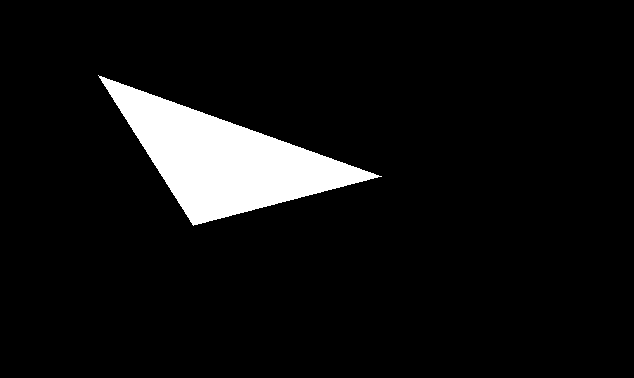

region_Id: 1 	Priority: 3 	label: Region


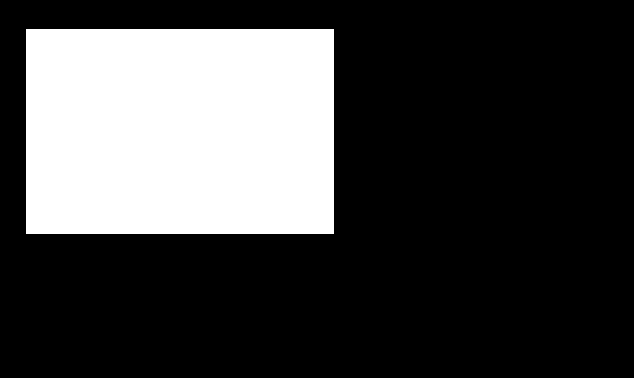

region_Id: 2 	Priority: 4 	label: malignant


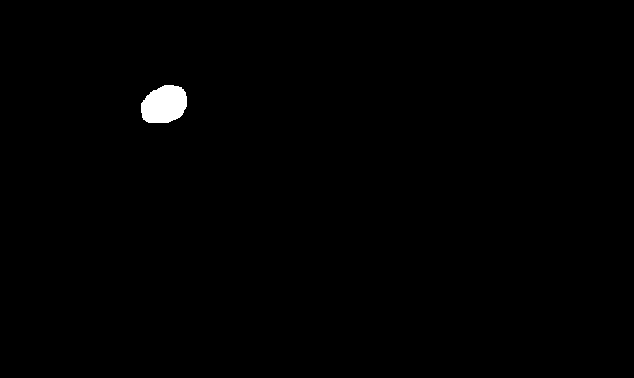

region_Id: 3 	Priority: 7 	label: normal


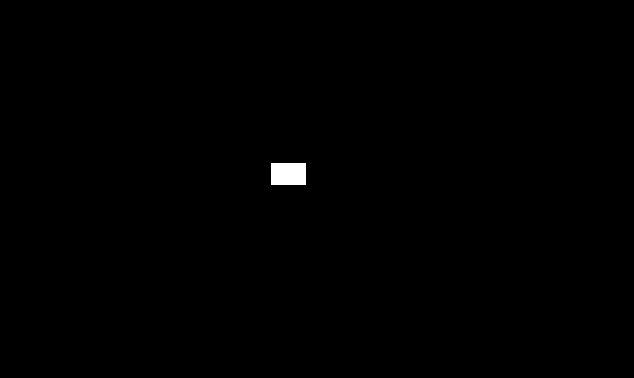

region_Id: 4 	Priority: 1 	label: fat


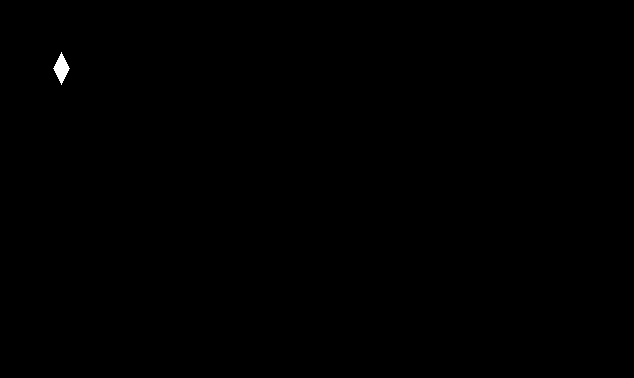

region_Id: 5 	Priority: 0 	label: null


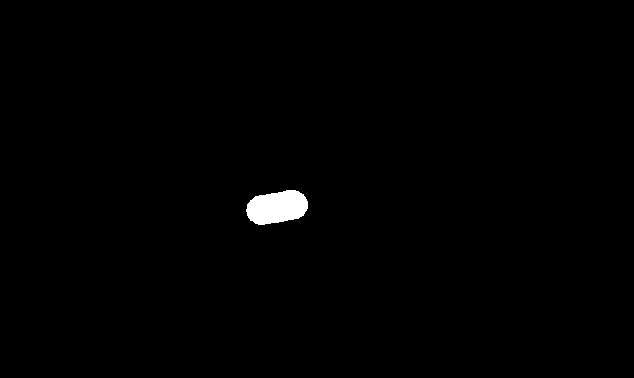

region_Id: 6 	Priority: 2 	label: lymph


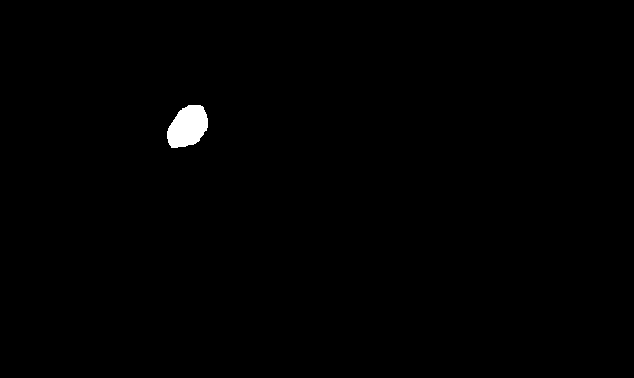

region_Id: 7 	Priority: 6 	label: ink


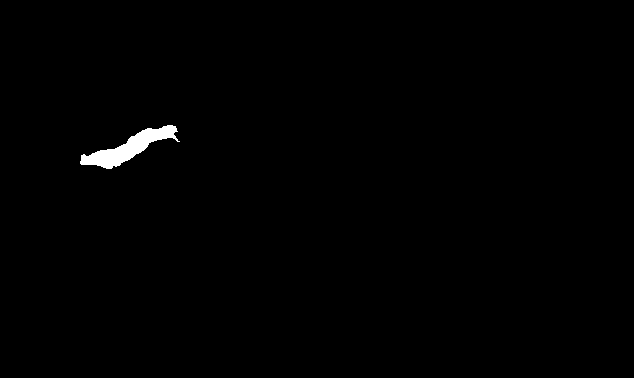

Total time to get & display 8 region_masks: 0.089


sum of smaller masks


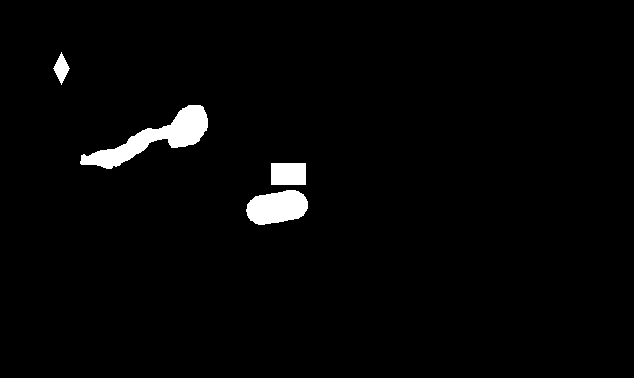

In [5]:
# Test and display function get_region_mask()
# Test / demo summing masks

t0 = time.time()
n_regions = 8

thumbnail_size = tuple((np.array(image_dimensions) / thumbnail_divisor).astype(np.int))
num_thumb_size = (thumbnail_size[1], thumbnail_size[0])

uber_mask = np.zeros(num_thumb_size).astype(np.uint8)

for r_id in range(n_regions):
    region_coords = region_id_dict[r_id+1]['coords']
    region_priority = region_id_dict[r_id+1]['Priority']
    region_label = region_id_dict[r_id+1]['class_label_text']
    thumbnail_divisor = 200
    print('region_Id:', r_id, '\tPriority:', region_priority, '\tlabel:', region_label)
    mask_im, img = get_region_mask(region_coords, thumbnail_divisor, image_dimensions)
    if r_id > 2:
        uber_mask += mask_im
    display(img)
    

uber_mask[uber_mask > 0] = 1
uber_mask_im = Image.fromarray(uber_mask * 255)
print('Total time to get & display %i region_masks: %0.3f'%(n_regions, time.time() - t0))
print('\n\nsum of smaller masks')
display(uber_mask_im)

# Use Case 2 - (paraphrased)

## Givin a WSI, an Annotation File and an Annotation Labels priority dictionary file

1) Annotation file must follow the QuPath Annotation convention. <br>
2) Labels dictionary required to assign priority. <br>
****
```python
# read the Annotation File and the labels priority dict into a regions dictionary:
# read the regions dictionary into a labels dict
#    for each label
#        get the mask,
#        add the patches to the tfrecord or write the files,

```

In [6]:
# Test - demo priority dictionary conversion: regions_dict_to_priority_dict(regions_dict)

regions_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
priority_dict, priority_list = regions_dict_to_priority_dict(regions_dict)

for p in priority_list:
    lbl_dict_list = priority_dict[p]
    print('\nPriority:', p, '\t(%i dictionaries)'%(len(lbl_dict_list)))
    for lbl_dict in lbl_dict_list:
        for k, v in lbl_dict.items():
            if isinstance(v, np.ndarray):
                print('%20s:'%(k), v[0,:])
                for v_ix in range(len(v) - 1):
                    print('%20s '%(' '), v[v_ix+1,:])
            else:
                print('%20s:'%(k), v)


Priority: 7 	(1 dictionaries)
    class_label_text: normal
      class_label_Id: 7
            Priority: 7
    region_geo_shape: Rectangle
              coords: [54263.393564 32703.707487]
                      [61076.004787 32703.707487]
                      [61076.004787 36961.589501]
                      [54263.393564 36961.589501]
           region_Id: 4

Priority: 6 	(1 dictionaries)
    class_label_text: ink
      class_label_Id: 6
            Priority: 6
    region_geo_shape: Area
              coords: [33423.445313 25154.421875]
                      [33309.050781 25268.814453]
                      [33194.65625  25268.814453]
                      [33080.265625 25383.207031]
                      [32965.871094 25383.207031]
                      [32794.28125  25554.794922]
                      [32737.085938 25497.599609]
                      [32737.085938 25383.207031]
                      [32622.693359 25497.599609]
                      [32508.300781 25497.599609]
    

                      [23313.818359 33079.863281]
                      [23313.818359 33065.753906]
                      [23320.871094 33058.703125]
                      [23327.923828 33058.703125]
                      [23334.978516 33051.648438]
                      [23342.03125  33058.703125]
                      [23349.085938 33058.703125]
                      [23391.408203 33101.023438]
                      [23391.408203 33115.132813]
                      [23370.246094 33136.292969]
                      [23363.193359 33136.292969]
                      [23356.138672 33143.34375 ]
                      [23363.193359 33143.34375 ]
                      [23370.246094 33150.398438]
                      [23363.193359 33150.398438]
                      [23356.138672 33157.453125]
                      [23370.246094 33157.453125]
                      [23377.300781 33164.507813]
                      [23405.515625 33164.507813]
                      [23412.568359 33171.558594]


                      [35253.726563 25840.777344]
                      [35253.726563 25611.992188]
                      [35024.941406 25383.207031]
                      [34910.550781 25383.207031]
                      [34796.15625  25268.814453]
                      [34567.371094 25268.814453]
                      [34452.980469 25154.421875]
                      [33423.445313 25154.421875]
           region_Id: 8

Priority: 5 	(1 dictionaries)
    class_label_text: offset
      class_label_Id: 5
            Priority: 5
    region_geo_shape: Points
              coords: [19655.197266 15142.376953]
                      [38654.078125 45070.019531]
                      [76384.875    35296.066406]
           region_Id: 1

Priority: 4 	(1 dictionaries)
    class_label_text: malignant
      class_label_Id: 4
            Priority: 4
    region_geo_shape: Polygon
              coords: [28390.160156 22008.619141]
                      [28390.160156 21779.833984]
                      [2

In [7]:
"""                             
heirarchical_mask_dict = get_heirarchical_mask_dict(run_parameters)

Args:
    run_parameters:             with keys:
                                    csv_file_name
                                    xml_file_name
                                    thumbnail_divisor
                                    wsi_filename
Returns:
    heirarchical_mask_dict:     {label_1: mask_image, ...}
"""  

def get_labeled_patch_location_arrays_for_image_level(run_parameters):
    for k, v in run_parameters.items():
        print('%23s: %s'%(k,v))

data_dir = '../../DigiPath_MLTK_data'
output_dir = '../../DigiPath_MLTK_data/annotation_test/results'
if os.path.isdir(output_dir) == False:
    os.makedirs(output_dir)

wsi_file = 'RegistrationDevData/e39a8d60a56844d695e9579bce8f0335.tiff'
wsi_file = os.path.join(data_dir, wsi_file)
csv_file = 'wsi_annotation_sample/class_label_id.csv'
csv_file = os.path.join(data_dir, csv_file)
xml_file = 'wsi_annotation_sample/e39a8d60a56844d695e9579bce8f0335.xml'
xml_file = os.path.join(data_dir, xml_file)

run_parameters = {'method': 'annotations_to_dir', 
                  'output_dir': output_dir,
                  'wsi_filename': wsi_file, 
                  'csv_file_name': csv_file,
                  'xml_file_name': xml_file,
                  'thumbnail_divisor': 200, 
                  'patch_stride_fraction': 1, 
                  'image_level': 1.0, 
                  'patch_select_method': 'annotation_xml', 
                  'patch_height': 224, 
                  'patch_width': 224, 
                  'threshold': 0}

get_labeled_patch_location_arrays_for_image_level(run_parameters)

                 method: annotations_to_dir
             output_dir: ../../DigiPath_MLTK_data/annotation_test/results
           wsi_filename: ../../DigiPath_MLTK_data/RegistrationDevData/e39a8d60a56844d695e9579bce8f0335.tiff
          csv_file_name: ../../DigiPath_MLTK_data/wsi_annotation_sample/class_label_id.csv
          xml_file_name: ../../DigiPath_MLTK_data/wsi_annotation_sample/e39a8d60a56844d695e9579bce8f0335.xml
      thumbnail_divisor: 200
  patch_stride_fraction: 1
            image_level: 1.0
    patch_select_method: annotation_xml
           patch_height: 224
            patch_width: 224
              threshold: 0


mask for normal


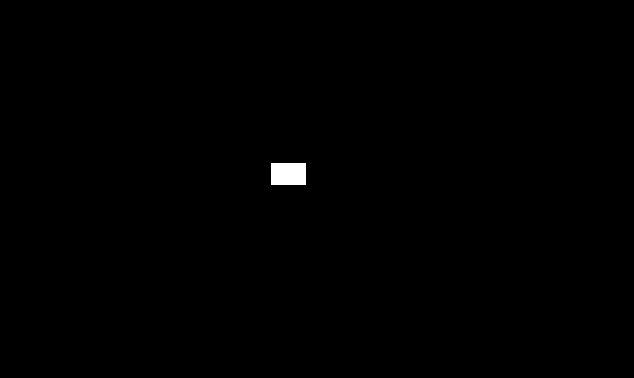

mask for ink


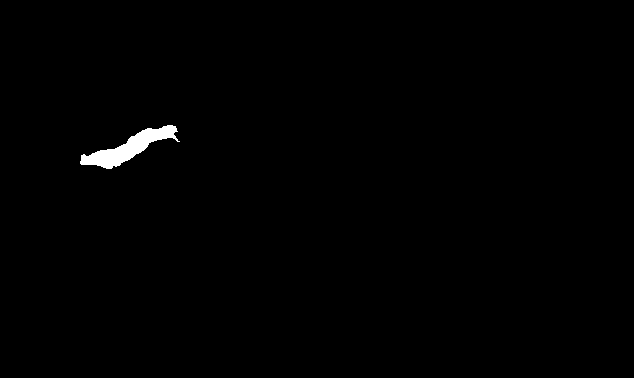

mask for offset


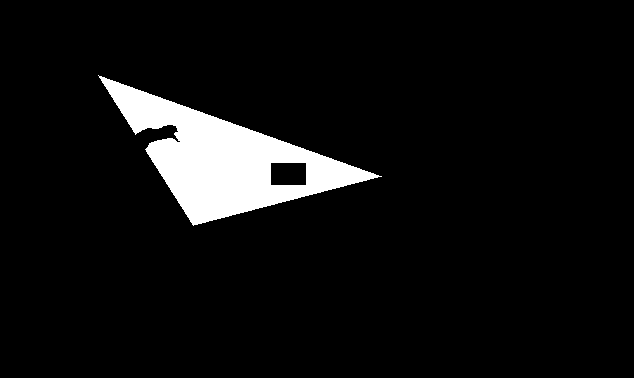

mask for malignant


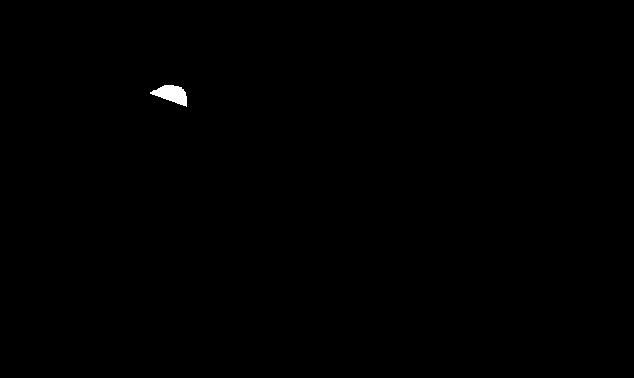

mask for Region


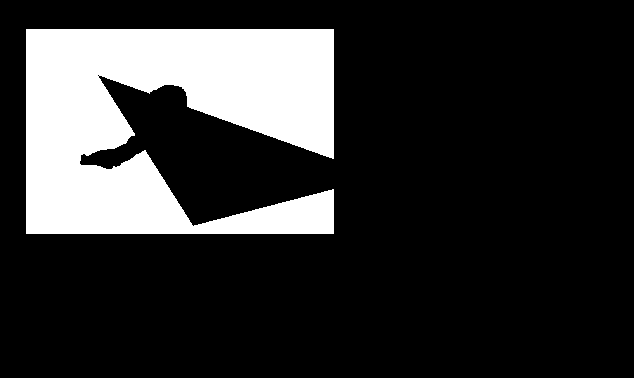

lymph Is Empty Mask
fat Is Empty Mask
null Is Empty Mask
total run time: 0.093


In [8]:
# Test get_heirarchical_mask_dict

t0 = time.time()
heirarchical_mask_dict = get_heirarchical_mask_dict(run_parameters)

for merge_label, merged_lbl_msk in heirarchical_mask_dict.items():
    if merged_lbl_msk.sum() == 0:
        print(merge_label, 'Is Empty Mask')
    else:
        m_lbl_im = Image.fromarray((merged_lbl_msk.astype(np.uint8) * 255))
        print('mask for %s'%(merge_label))
        display(m_lbl_im)
    
print('total run time: %0.3f'%(time.time() - t0))